In [1]:
from Load_Data_for_Modelling_Function import Data_for_Model
from Load_Data_for_Modelling_Interpolation import Interpolation

data = Data_for_Model(0,1800)
df_Int, Interpoliertes_df = Interpolation(0,1800,0)

ModuleNotFoundError: No module named 'Load_Data_for_Modelling_Function'

In [ ]:
from Fensterung_Scaling_CNN_ValData_Interpolation_Test import Fensterung_Scale

# Falls Validations Daten benötigt werden ohne Interpolation 
X_train_scaled, X_val_scaled, X_test_scaled, Y_train_scaled, Y_val_scaled, Y_test_scaled, Y_train, Y_val, Y_test, scalers_features, scaler_labels, Angepasste_Blechnummern_test = Fensterung_Scale(data, Validation_data=1, random=8, Train_Test_Split=2, window_size=10)
# Falls Validations Daten benötigt und interpoliert wird
X_train_scaled, X_val_scaled, X_test_scaled, Y_train_scaled, Y_val_scaled, Y_test_scaled, Y_train, Y_val, Y_test, scalers_features, scaler_labels, X_test_scaled_int, Y_test_interpolation, Blechnummern_Test_Int = Fensterung_Scale(df_Int, interpoliertesdf=Interpoliertes_df, Validation_data=1, random=8, Train_Test_Split=2, window_size=10, Interpolation=1)
# Falls keine Validationsdaten benötigt werden 
#X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled, Y_train, Y_test, scalers_features, scaler_labels = Fensterung_Scale(Validation_data=0, random=42)

In [1]:
# Aktuell bestes Modell aufbauen 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import kerastuner as kt
import shutil
import os
import json
import gc
from sklearn.metrics import mean_absolute_error


def bestes_model_CNN(X_train_scaled, X_val_scaled, X_test_scaled, Y_train_scaled, Y_val_scaled, Y_test_scaled, Y_train, Y_val, Y_test, scalers_features, scaler_labels, X_test_scaled_int=None, Y_test_interpolation=None, Blechnummern_Test_Int=None, n=0, Int=1 ):
      
    Y_train = np.squeeze(Y_train)
    Y_test = np.squeeze(Y_test)
    Y_val =np.squeeze(Y_val)
    Y_train_scaled = np.squeeze(Y_train_scaled)
    Y_val_scaled = np.squeeze(Y_val_scaled)
    
    if Int ==1:
        Y_test_interpolation = np.squeeze(Y_test_interpolation)
        
        print(Y_test_interpolation.shape)
        print(X_test_scaled_int.shape)
    
    # TensorFlow-Sitzung zurücksetzen
    tf.keras.backend.clear_session()
    gc.collect()

# CNN Modell definieren
    input_layer = layers.Input(shape=(10,11))

    # # Convolutional Layers
    # conv_1 = layers.Conv1D(filters=320, kernel_size=3, activation='relu', strides=1, padding='same', kernel_regularizer=keras.regularizers.l2(0.008))(input_layer)
    # pool_1 = layers.MaxPooling1D(pool_size=1)(conv_1)
    # conv_2 = layers.Conv1D(filters=288, kernel_size=5, activation='relu', padding='same', strides=1, kernel_regularizer=keras.regularizers.l2(0.004))(pool_1)
    # pool_2 = layers.MaxPooling1D(pool_size=2)(conv_2)
    # conv_3 = layers.Conv1D(filters=128, kernel_size=4, activation='relu', padding='same', strides=1, kernel_regularizer=keras.regularizers.l2(0.002))(pool_2)
    # pool_3 = layers.MaxPooling1D(pool_size=2)(conv_3)
    # conv_4 = layers.Conv1D(filters=416, kernel_size=5, activation='relu', padding='same', strides=1, kernel_regularizer=keras.regularizers.l2(0.01))(pool_3)
    # pool_4 = layers.MaxPooling1D(pool_size=2)(conv_4)
    
    conv_1 = layers.Conv1D(filters=160, kernel_size=2, activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01))(input_layer)
    pool_1 = layers.MaxPooling1D(pool_size=2)(conv_1)
    conv_2 = layers.Conv1D(filters=480, kernel_size=4, activation='relu', padding='same', strides=1, kernel_regularizer=keras.regularizers.l2(0.01))(pool_1)
    pool_2 = layers.MaxPooling1D(pool_size=2)(conv_2)

    flatten = layers.Flatten()(pool_2)

    # print(flatten)
    # print(type(flatten))
    # print(flatten.shape)

    # # Fully Connected Layers
    # dense_layer = layers.Dense(448, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001))(flatten)
    # dense_layer_1 = layers.Dense(96, activation='relu', kernel_regularizer=keras.regularizers.l2(0.003))(dense_layer)
    # dense_layer_2 = layers.Dense(448, activation='relu', kernel_regularizer=keras.regularizers.l2(0.008))(dense_layer_1)
    # dense_layer_3 = layers.Dense(160, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.003))(dense_layer_2)
    # dense_layer_4 = layers.Dense(320, activation='relu', kernel_regularizer=keras.regularizers.l2(0.007))(dense_layer_3)
    
     #Hyperparametersuche 3
    dense_layer = layers.Dense(64, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.01))(flatten)
    

    # Output Layers definieren
    X_output = layers.Dense(1, activation='linear', name='Verstellweg_X')(dense_layer)
    Y_output = layers.Dense(1, activation='linear', name='Verstellweg_Y')(dense_layer)
    Phi_output = layers.Dense(1, activation='linear', name='Verstellweg_Phi')(dense_layer)

    # Liste erstellen für alle Outputs
    outputs = [X_output, Y_output, Phi_output]

    # Modell definieren 
    model = keras.Model(inputs=input_layer, outputs=outputs)

    # # Kompilieren des Modells
    # model.compile(optimizer=keras.optimizers.Adam(0.00013453713072694953), 
    #             loss=['mean_absolute_error', 'mean_absolute_error', 'mean_absolute_error'], 
    #             metrics={'Verstellweg_X': 'mae', 'Verstellweg_Y': 'mae', 'Verstellweg_Phi': 'mae'})
    
        # Kompilieren des Modells
    model.compile(optimizer=keras.optimizers.Adam(0.0003255639325303961), 
                loss=['mean_absolute_error', 'mean_absolute_error', 'mean_absolute_error'], 
                metrics={'Verstellweg_X': 'mae', 'Verstellweg_Y': 'mae', 'Verstellweg_Phi': 'mae'})


    # Modell zusammenfassen
    #model.summary()

    # Define early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    CNN = model.fit(X_train_scaled, [Y_train[:,0], Y_train[:,1], Y_train[:,2]],
                            epochs=30,
                            validation_data=(X_val_scaled, [Y_val[:, 0], Y_val[:, 1], Y_val[:, 2]]),
                            callbacks=[early_stopping])
    if Int==1:
        # Vorhersagen für den Testdatensatz erstellen
        predictions_alle = model.predict(X_test_scaled)
        X_p_alle, Y_p_alle, Phi_p_alle = predictions_alle
        
        predictions_Versuche = model.predict(X_test_scaled_int)
        X_p_versuch, Y_p_versuch, Phi_p_versuch = predictions_Versuche

        #print(predictions_Versuche.shape)
        print(predictions_Versuche)
        print(X_p_versuch.shape)
        print(X_p_versuch)
        print(Y_test_interpolation[:,0].shape)
        print(Y_test_interpolation[:,0])
        
            #print(predictions)
        mae_X_all = mean_absolute_error(Y_test[:, 0], X_p_alle)
        mae_Y_all = mean_absolute_error(Y_test[:, 1], Y_p_alle)
        mae_Phi_all = mean_absolute_error(Y_test[:, 2], Phi_p_alle)
        
        mae_X_versuch = mean_absolute_error(Y_test_interpolation[:, 0], X_p_versuch)
        mae_Y_versuch = mean_absolute_error(Y_test_interpolation[:, 1], Y_p_versuch)
        mae_Phi_versuch = mean_absolute_error(Y_test_interpolation[:, 2], Phi_p_versuch)
        
            # Fehler in einen DataFrame konvertieren
        MAEs_CNN = pd.DataFrame({
            'Interpolationsfaktor': [n],
            'MAE_X_AlleDaten': [mae_X_all],
            'MAE_Y_AlleDaten': [mae_Y_all],
            'MAE_Phi_AlleDaten': [mae_Phi_all],
            'MAE_X_Versuchsdaten': [mae_X_versuch],
            'MAE_Y_Versuchsdaten': [mae_Y_versuch],
            'MAE_Phi_Versuchsdaten': [mae_Phi_versuch]})

        print(f"Dataframe für MAEs CNN: {MAEs_CNN}")
        
    else:
        # Vorhersagen für den Testdatensatz erstellen
        predictions_alle = model.predict(X_test_scaled)
        X_p_alle, Y_p_alle, Phi_p_alle = predictions_alle
        
        print(X_p_alle.shape)
        
        mae_X_all = mean_absolute_error(Y_test[:, 0], X_p_alle)
        mae_Y_all = mean_absolute_error(Y_test[:, 1], Y_p_alle)
        mae_Phi_all = mean_absolute_error(Y_test[:, 2], Phi_p_alle)
        
        print(mae_X_all.shape)
        print(mae_X_all)
        print(n)
        
            # Fehler in einen DataFrame konvertieren
        MAEs_CNN = pd.DataFrame({
            'Interpolationsfaktor': [n],
            'MAE_X_AlleDaten': [mae_X_all],
            'MAE_Y_AlleDaten': [mae_Y_all],
            'MAE_Phi_AlleDaten': [mae_Phi_all],
            'MAE_X_Versuchsdaten': ['N/A'],
            'MAE_Y_Versuchsdaten': ['N/A'],
            'MAE_Phi_Versuchsdaten': ['N/A']})
        
    
    return MAEs_CNN

def bestes_model_Transformer(X_train_scaled, X_val_scaled, X_test_scaled, Y_train_scaled, Y_val_scaled, Y_test_scaled, Y_train, Y_val, Y_test, scalers_features, scaler_labels, X_test_scaled_int=None, Y_test_interpolation=None, Blechnummern=None, n=0, Int=1 ):
      
    Y_train = np.squeeze(Y_train)
    Y_test = np.squeeze(Y_test)
    Y_val =np.squeeze(Y_val)
    Y_train_scaled = np.squeeze(Y_train_scaled)
    Y_val_scaled = np.squeeze(Y_val_scaled)
    
    if Int==1:
        Y_test_interpolation = np.squeeze(Y_test_interpolation)
        
        print(Y_test_interpolation.shape)
        print(X_test_scaled_int.shape)
    
    
    
    # TensorFlow-Sitzung zurücksetzen
    tf.keras.backend.clear_session()
    gc.collect()
     
    # Transformer Encoder Block
    def transformer_encoder(inputs, head_size, num_heads, ff_dim_1, ff_dim_2,  dropout_1, dropout_2, kernel_size1, kernel_size2):
        # Normalization and Attention
        x = layers.LayerNormalization(epsilon=1e-6)(inputs)
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads)(x,x)
        x = layers.Dropout(dropout_1)(x)
        res = x + inputs

        # Feed Forward Part
        x = layers.LayerNormalization(epsilon=1e-6)(res)
        x = layers.Conv1D(filters=ff_dim_1, kernel_size=kernel_size1, activation="relu",padding='same')(x)
        x = layers.Dropout(dropout_2)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1, padding='same')(x)
        
        return x + res


    input_layer = layers.Input(shape=(10, 11))
        
    x = input_layer

    x = transformer_encoder(x, 250, 4, 288, 224, 0, 0.3, 3, 5)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    # Fully Connected Layers

        # Fully Connected Layers
    dense_layer = layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.002))(x)
    dense_layer_1 = layers.Dense(448, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense_layer)
    dense_layer_2 = layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0))(dense_layer_1)
    dense_layer_3 = layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0))(dense_layer_2)

    # Output Layers
    X_output = layers.Dense(1, activation='linear', name='Verstellweg_X')(dense_layer_3)
    Y_output = layers.Dense(1, activation='linear', name='Verstellweg_Y')(dense_layer_3)
    Phi_output = layers.Dense(1, activation='linear', name='Verstellweg_Phi')(dense_layer_3)

    outputs = [X_output, Y_output, Phi_output]

    model = keras.Model(inputs=input_layer, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(0.0003269360363083118), 
                    loss=['mean_absolute_error', 'mean_absolute_error', 'mean_absolute_error'], 
                    metrics={'Verstellweg_X': 'mae', 'Verstellweg_Y': 'mae', 'Verstellweg_Phi': 'mae'})

    model.summary()
    
    # Define early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    
    Transformer_model = model.fit(X_train_scaled, [Y_train[:,0], Y_train[:,1], Y_train[:,2]],
                            epochs=30,
                            validation_data=(X_val_scaled, [Y_val[:, 0], Y_val[:, 1], Y_val[:, 2]]),
                            callbacks=[early_stopping])
    if Int==1:
            
        # Vorhersagen für den Testdatensatz erstellen
        predictions_alle = model.predict(X_test_scaled)
        X_p_alle, Y_p_alle, Phi_p_alle = predictions_alle
        
        predictions_Versuche = model.predict(X_test_scaled_int)
        X_p_versuch, Y_p_versuch, Phi_p_versuch = predictions_Versuche

        #print(X_train_flat.shape)
        #print(X_val_flat.shape)
            #print(predictions)
        mae_X_all = mean_absolute_error(Y_test[:, 0], X_p_alle)
        mae_Y_all = mean_absolute_error(Y_test[:, 1], Y_p_alle)
        mae_Phi_all = mean_absolute_error(Y_test[:, 2], Phi_p_alle)
        
        mae_X_versuch = mean_absolute_error(Y_test_interpolation[:, 0], X_p_versuch)
        mae_Y_versuch = mean_absolute_error(Y_test_interpolation[:, 1], Y_p_versuch)
        mae_Phi_versuch = mean_absolute_error(Y_test_interpolation[:, 2], Phi_p_versuch)
        
            # Fehler in einen DataFrame konvertieren
        MAEs_Transformer = pd.DataFrame({
            'Interpolationsfaktor': [n],
            'MAE_X_AlleDaten': [mae_X_all],
            'MAE_Y_AlleDaten': [mae_Y_all],
            'MAE_Phi_AlleDaten': [mae_Phi_all],
            'MAE_X_Versuchsdaten': [mae_X_versuch],
            'MAE_Y_Versuchsdaten': [mae_Y_versuch],
            'MAE_Phi_Versuchsdaten': [mae_Phi_versuch]})

    else:
           # Vorhersagen für den Testdatensatz erstellen
        predictions_alle = model.predict(X_test_scaled)
        X_p_alle, Y_p_alle, Phi_p_alle = predictions_alle
        
        mae_X_all = mean_absolute_error(Y_test[:, 0], X_p_alle)
        mae_Y_all = mean_absolute_error(Y_test[:, 1], Y_p_alle)
        mae_Phi_all = mean_absolute_error(Y_test[:, 2], Phi_p_alle)
        
            # Fehler in einen DataFrame konvertieren
        MAEs_Transformer = pd.DataFrame({
            'Interpolationsfaktor': [n],
            'MAE_X_AlleDaten': [mae_X_all],
            'MAE_Y_AlleDaten': [mae_Y_all],
            'MAE_Phi_AlleDaten': [mae_Phi_all],
            'MAE_X_Versuchsdaten': ['N/A'],
            'MAE_Y_Versuchsdaten': ['N/A'],
            'MAE_Phi_Versuchsdaten': ['N/A']})
        
        
        
    return MAEs_Transformer




C:\Users\corvi\AppData\Local\Temp\ipykernel_28920\3263458536.py:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [4]:
import random 
from Splitting_Scaling_Function_SkalierungY import Split_Scaling
from Load_Data_for_Modelling_Function import Data_for_Model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from Fensterung_Scaling_CNN_ValData_Interpolation_Test import Fensterung_Scale
from sklearn.metrics import mean_absolute_error
import pandas as pd
from Load_Data_for_Modelling_Interpolation import Interpolation


# random.seed(1)
# Random_numbers =  [random.randint(0, 100) for _ in range(10)]
# print(Random_numbers)


# MAE_StandardSplit_df = pd.DataFrame(columns=['CV', 'Datentyp','Error', 'X', 'y', 'phi'])
# MAE_BlechSplit_df = pd.DataFrame(columns=['CV', 'Datentyp','Error', 'X', 'y', 'phi'])

#data = Data_for_Model(0,1800)

# Initialisierung der Variablen für Fehlerdaten
MAEs_Interpolation_CNN = []
MAEs_Interpolation_Transformer = []
Random_Split = 11

for n in range(0,4):
    
    if n < 1:
        print(f'Im Loop der if Abfrage_{n}')
        data = Data_for_Model(0,1800)
        X_train_scaled, X_val_scaled, X_test_scaled, Y_train_scaled, Y_val_scaled, Y_test_scaled, Y_train, Y_val, Y_test, scalers_features, scaler_labels, Angepasste_Blechnummern_test = Fensterung_Scale(data, Validation_data=1, random=Random_Split, Train_Test_Split=2, window_size=10)
        MAEs_CNN = bestes_model_CNN(X_train_scaled, X_val_scaled, X_test_scaled, Y_train_scaled, Y_val_scaled, Y_test_scaled, Y_train, Y_val, Y_test, scalers_features, scaler_labels, n=n, Int=0 )
        MAEs_trans = bestes_model_Transformer(X_train_scaled, X_val_scaled, X_test_scaled, Y_train_scaled, Y_val_scaled, Y_test_scaled, Y_train, Y_val, Y_test, scalers_features, scaler_labels, n=n, Int=0 )
        MAEs_CNN.insert(loc=0, column='CV', value = Random_Split)
        MAEs_trans.insert(loc=0, column='CV', value = Random_Split)
        MAEs_CNN.insert(loc=0, column='Modell', value = 'CNN')
        MAEs_trans.insert(loc=0, column='Modell', value = 'Transformer')
        MAEs_Interpolation_CNN.append(MAEs_CNN)
        MAEs_Interpolation_Transformer.append(MAEs_trans)
        
    else:
        print(n)
        df_Int, Interpoliertes_df = Interpolation(0,1800,n)
        X_train_scaled, X_val_scaled, X_test_scaled, Y_train_scaled, Y_val_scaled, Y_test_scaled, Y_train, Y_val, Y_test, scalers_features, scaler_labels, X_test_scaled_int, Y_test_interpolation, Blechnummern_Test_Int = Fensterung_Scale(df_Int, interpoliertesdf= Interpoliertes_df,Validation_data=1, random=Random_Split, Train_Test_Split =2, size=0.2, Interpolation=1)
        MAEs_CNN = bestes_model_CNN(X_train_scaled, X_val_scaled, X_test_scaled, Y_train_scaled, Y_val_scaled, Y_test_scaled, Y_train, Y_val, Y_test, scalers_features, scaler_labels, X_test_scaled_int, Y_test_interpolation, Blechnummern_Test_Int, n=n )
        MAEs_trans = bestes_model_Transformer(X_train_scaled, X_val_scaled, X_test_scaled, Y_train_scaled, Y_val_scaled, Y_test_scaled, Y_train, Y_val, Y_test, scalers_features, scaler_labels, X_test_scaled_int=X_test_scaled_int, Y_test_interpolation=Y_test_interpolation, n=n )
        MAEs_CNN.insert(loc=0, column='CV', value = Random_Split)
        MAEs_trans.insert(loc=0, column='CV', value = Random_Split)
        MAEs_CNN.insert(loc=0, column='Modell', value = 'CNN')
        MAEs_trans.insert(loc=0, column='Modell', value = 'Transformer')
        MAEs_Interpolation_CNN.append(MAEs_CNN)
        MAEs_Interpolation_Transformer.append(MAEs_trans)
    
MAEs_Interpolation_CNN_df = pd.concat(MAEs_Interpolation_CNN, axis=0)
MAEs_Interpolation_Transformer_df =pd.concat(MAEs_Interpolation_Transformer, axis=0)
    
    
# Ausgabe der DataFrames
print("MAE CNN Interpolation:")
print(MAEs_Interpolation_CNN_df)
print("\nMAE Transformer Interpolation:")
print(MAEs_Interpolation_Transformer_df)

Im Loop der if Abfrage_0
Anzahl der Zeilen im finalen DataFrame: 255600
None
142
254180
142.0
Richtige Blechnummern umgerechnet der Validierungsdaten [143, 147, 169, 159, 62, 61, 160, 149, 164, 38, 142, 103, 50, 37]
Richtige Blechnummern umgerechnet der Testdaten [82, 130, 141, 114, 107, 19, 102, 64, 71, 109, 120, 104, 145, 34]
Blechnummern für Validierungsdaten, abgezählt vom Array nicht die Originaldaten [116, 120, 141, 131, 49, 48, 132, 122, 136, 25, 115, 78, 37, 24]
Blechnummern für Testdaten, abgezählt vom Array nicht die Originaldaten[69, 104, 114, 89, 82, 6, 77, 51, 58, 84, 95, 79, 118, 21]
25060
Shape nach dem Random Sampling des Arrays von X_val: (25060, 10, 11)
Shape nach dem Random Sampling des Arrays von X_train: (204060, 10, 11)
Shape nach dem Random Sampling des Arrays von Y_train: (204060, 1, 3)
(25060, 1, 3)
Shape für die Features der gesamten Trainingsdaten, also im Falle einer Interpolation mit allen Daten (204060, 10, 11)
Shape für die Features der gesamten Testdaten

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 11)    │         22 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 11)    │     47,011 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 11)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 11)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 11)    │         22 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 288)   │      9,792 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 10, 288)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 10, 11)    │      3,179 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 11)    │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 10)        │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │      5,632 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 448)       │    229,824 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │     14,368 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      1,056 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │         33 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │         33 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │         33 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 311,005 (1.19 MB)

 Trainable params: 311,005 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
6377/6377 ━━━━━━━━━━━━━━━━━━━━ 115s 17ms/step - Verstellweg_Phi_mae: 1.5634 - Verstellweg_X_mae: 0.2685 - Verstellweg_Y_mae: 0.4217 - loss: 2.4111 - val_Verstellweg_Phi_mae: 1.5200 - val_Verstellweg_X_mae: 0.0079 - val_Verstellweg_Y_mae: 0.4431 - val_loss: 2.0310
Epoch 2/30
6377/6377 ━━━━━━━━━━━━━━━━━━━━ 104s 16ms/step - Verstellweg_Phi_mae: 0.3505 - Verstellweg_X_mae: 0.1958 - Verstellweg_Y_mae: 0.1940 - loss: 0.8001 - val_Verstellweg_Phi_mae: 1.3763 - val_Verstellweg_X_mae: 0.0111 - val_Verstellweg_Y_mae: 0.4077 - val_loss: 1.8482
Epoch 3/30
6377/6377 ━━━━━━━━━━━━━━━━━━━━ 105s 16ms/step - Verstellweg_Phi_mae: 0.2670 - Verstellweg_X_mae: 0.0754 - Verstellweg_Y_mae: 0.1706 - loss: 0.5641 - val_Verstellweg_Phi_mae: 1.3195 - val_Verstellweg_X_mae: 0.0107 - val_Verstellweg_Y_mae: 0.3726 - val_loss: 1.7517
Epoch 4/30
6377/6377 ━━━━━━━━━━━━━━━━━━━━ 106s 17ms/step - Verstellweg_Phi_mae: 0.1958 - Verstellweg_X_mae: 0.0707 - Verstellweg_Y_mae: 0.1477 - loss: 0.4618 - val_Verstellweg

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 11)    │         22 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 11)    │     47,011 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 11)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 11)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 11)    │         22 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 288)   │      9,792 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 10, 288)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 10, 11)    │      3,179 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 11)    │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 10)        │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │      5,632 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 448)       │    229,824 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │     14,368 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      1,056 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │         33 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │         33 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │         33 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 311,005 (1.19 MB)

 Trainable params: 311,005 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
11971/11971 ━━━━━━━━━━━━━━━━━━━━ 218s 18ms/step - Verstellweg_Phi_mae: 0.4841 - Verstellweg_X_mae: 0.2036 - Verstellweg_Y_mae: 0.9036 - loss: 1.7156 - val_Verstellweg_Phi_mae: 0.5395 - val_Verstellweg_X_mae: 0.2363 - val_Verstellweg_Y_mae: 0.3851 - val_loss: 1.1992
Epoch 2/30
11971/11971 ━━━━━━━━━━━━━━━━━━━━ 206s 17ms/step - Verstellweg_Phi_mae: 0.2419 - Verstellweg_X_mae: 0.0762 - Verstellweg_Y_mae: 0.2344 - loss: 0.5874 - val_Verstellweg_Phi_mae: 0.5535 - val_Verstellweg_X_mae: 0.2390 - val_Verstellweg_Y_mae: 0.3483 - val_loss: 1.1706
Epoch 3/30
11971/11971 ━━━━━━━━━━━━━━━━━━━━ 204s 17ms/step - Verstellweg_Phi_mae: 0.2018 - Verstellweg_X_mae: 0.0723 - Verstellweg_Y_mae: 0.1964 - loss: 0.4992 - val_Verstellweg_Phi_mae: 0.5108 - val_Verstellweg_X_mae: 0.2336 - val_Verstellweg_Y_mae: 0.3287 - val_loss: 1.0997
Epoch 4/30
11971/11971 ━━━━━━━━━━━━━━━━━━━━ 204s 17ms/step - Verstellweg_Phi_mae: 0.1685 - Verstellweg_X_mae: 0.0704 - Verstellweg_Y_mae: 0.1807 - loss: 0.4456 - val_Ver

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 11)    │         22 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 11)    │     47,011 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 11)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 11)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 11)    │         22 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 288)   │      9,792 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 10, 288)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 10, 11)    │      3,179 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 11)    │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 10)        │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │      5,632 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 448)       │    229,824 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │     14,368 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      1,056 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │         33 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │         33 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │         33 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 311,005 (1.19 MB)

 Trainable params: 311,005 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
17565/17565 ━━━━━━━━━━━━━━━━━━━━ 326s 18ms/step - Verstellweg_Phi_mae: 0.6629 - Verstellweg_X_mae: 0.1577 - Verstellweg_Y_mae: 0.3644 - loss: 1.3008 - val_Verstellweg_Phi_mae: 0.3635 - val_Verstellweg_X_mae: 0.2625 - val_Verstellweg_Y_mae: 0.2996 - val_loss: 0.9618
Epoch 2/30
17565/17565 ━━━━━━━━━━━━━━━━━━━━ 314s 18ms/step - Verstellweg_Phi_mae: 0.2894 - Verstellweg_X_mae: 0.0515 - Verstellweg_Y_mae: 0.2035 - loss: 0.5797 - val_Verstellweg_Phi_mae: 0.3649 - val_Verstellweg_X_mae: 0.0751 - val_Verstellweg_Y_mae: 0.2717 - val_loss: 0.7412
Epoch 3/30
17565/17565 ━━━━━━━━━━━━━━━━━━━━ 335s 19ms/step - Verstellweg_Phi_mae: 0.2440 - Verstellweg_X_mae: 0.0212 - Verstellweg_Y_mae: 0.1768 - loss: 0.4701 - val_Verstellweg_Phi_mae: 0.3909 - val_Verstellweg_X_mae: 0.0699 - val_Verstellweg_Y_mae: 0.2741 - val_loss: 0.7602
Epoch 4/30
17565/17565 ━━━━━━━━━━━━━━━━━━━━ 360s 20ms/step - Verstellweg_Phi_mae: 0.2173 - Verstellweg_X_mae: 0.0180 - Verstellweg_Y_mae: 0.1632 - loss: 0.4235 - val_Ver

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 11)    │         22 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 11)    │     47,011 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 11)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 11)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 11)    │         22 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 288)   │      9,792 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 10, 288)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 10, 11)    │      3,179 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 11)    │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 10)        │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │      5,632 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 448)       │    229,824 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │     14,368 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      1,056 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │         33 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │         33 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │         33 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 311,005 (1.19 MB)

 Trainable params: 311,005 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
23159/23159 ━━━━━━━━━━━━━━━━━━━━ 483s 21ms/step - Verstellweg_Phi_mae: 0.5665 - Verstellweg_X_mae: 0.1289 - Verstellweg_Y_mae: 0.3485 - loss: 1.1495 - val_Verstellweg_Phi_mae: 0.3959 - val_Verstellweg_X_mae: 0.0593 - val_Verstellweg_Y_mae: 0.3661 - val_loss: 0.8506
Epoch 2/30
23159/23159 ━━━━━━━━━━━━━━━━━━━━ 470s 20ms/step - Verstellweg_Phi_mae: 0.2802 - Verstellweg_X_mae: 0.0225 - Verstellweg_Y_mae: 0.2286 - loss: 0.5581 - val_Verstellweg_Phi_mae: 0.4819 - val_Verstellweg_X_mae: 0.0271 - val_Verstellweg_Y_mae: 0.3305 - val_loss: 0.8619
Epoch 3/30
23159/23159 ━━━━━━━━━━━━━━━━━━━━ 478s 21ms/step - Verstellweg_Phi_mae: 0.2430 - Verstellweg_X_mae: 0.0189 - Verstellweg_Y_mae: 0.2100 - loss: 0.4938 - val_Verstellweg_Phi_mae: 0.4332 - val_Verstellweg_X_mae: 0.0435 - val_Verstellweg_Y_mae: 0.3466 - val_loss: 0.8440
Epoch 4/30
23159/23159 ━━━━━━━━━━━━━━━━━━━━ 483s 21ms/step - Verstellweg_Phi_mae: 0.2153 - Verstellweg_X_mae: 0.0168 - Verstellweg_Y_mae: 0.1959 - loss: 0.4484 - val_Ver

In [5]:
print(MAEs_Interpolation_CNN)
print(MAEs_Interpolation_Transformer)

MAE_Interpolation_ges = pd.concat([MAEs_Interpolation_CNN_df,MAEs_Interpolation_Transformer_df], axis=0, ignore_index=True)

print(MAE_Interpolation_ges)

for Column in MAE_Interpolation_ges.columns:
        MAE_Interpolation_ges[Column] = MAE_Interpolation_ges[Column].astype(str).str.replace('.', ',')

Ordner = r'C:\Users\corvi\OneDrive - stud.tu-darmstadt.de\Desktop\Masterthesis\13_ExcelvonDaten_Code\Interpolation'

MAE_Interpolation_ges.to_csv(f'{Ordner}\Vergleich_CNN_Tranformer_Random11_Intfaktor0_3_x.csv', index=True, sep=';')

[  Modell  CV  Interpolationsfaktor  MAE_X_AlleDaten  MAE_Y_AlleDaten  \
0    CNN  11                     0         0.011333          0.46282   

   MAE_Phi_AlleDaten MAE_X_Versuchsdaten MAE_Y_Versuchsdaten  \
0           0.903583                 N/A                 N/A   

  MAE_Phi_Versuchsdaten  
0                   N/A  ,   Modell  CV  Interpolationsfaktor  MAE_X_AlleDaten  MAE_Y_AlleDaten  \
0    CNN  11                     1         0.027334         0.277894   

   MAE_Phi_AlleDaten  MAE_X_Versuchsdaten  MAE_Y_Versuchsdaten  \
0           0.308834             0.005428              0.20249   

   MAE_Phi_Versuchsdaten  
0               0.440865  ,   Modell  CV  Interpolationsfaktor  MAE_X_AlleDaten  MAE_Y_AlleDaten  \
0    CNN  11                     2         0.012873          0.27301   

   MAE_Phi_AlleDaten  MAE_X_Versuchsdaten  MAE_Y_Versuchsdaten  \
0           0.265983             0.012734             0.262136   

   MAE_Phi_Versuchsdaten  
0               0.187991  ,   Mode

C:\Users\corvi\AppData\Local\Temp\ipykernel_28920\3325388738.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  MAE_Interpolation_ges[Column] = MAE_Interpolation_ges[Column].astype(str).str.replace('.', ',')


        Modell    CV  Interpolationsfaktor  MAE_X_AlleDaten  MAE_Y_AlleDaten  \
0          CNN  11.0                   0.0         0.011333         0.462820   
1          CNN  11.0                   1.0         0.027334         0.277894   
2          CNN  11.0                   2.0         0.012873         0.273010   
3          CNN  11.0                   3.0         0.006475         0.232252   
4  Transformer  11.0                   0.0         0.440323         0.385579   
5  Transformer  11.0                   1.0         0.237481         0.370877   
6  Transformer  11.0                   2.0         0.032578         0.260510   
7  Transformer  11.0                   3.0         0.014374         0.272053   

   MAE_Phi_AlleDaten  MAE_X_Versuchsdaten  MAE_Y_Versuchsdaten  \
0           0.742069                  NaN                  NaN   
1           0.308834             0.005428             0.202490   
2           0.265983             0.012734             0.262136   
3           0.2

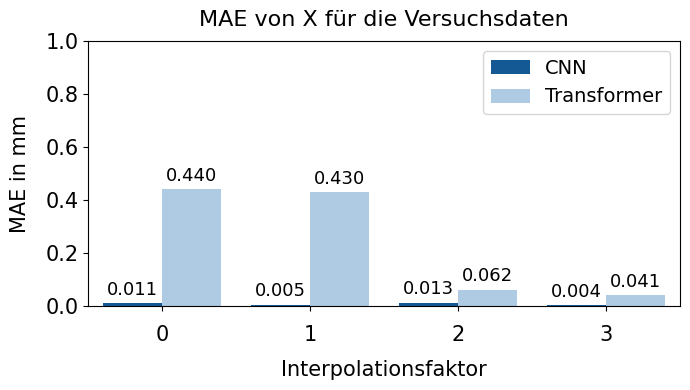

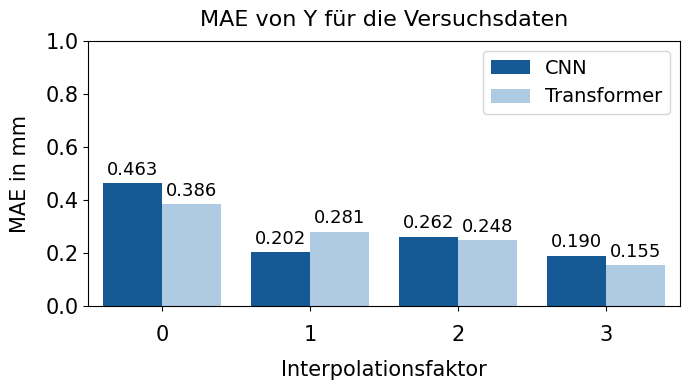

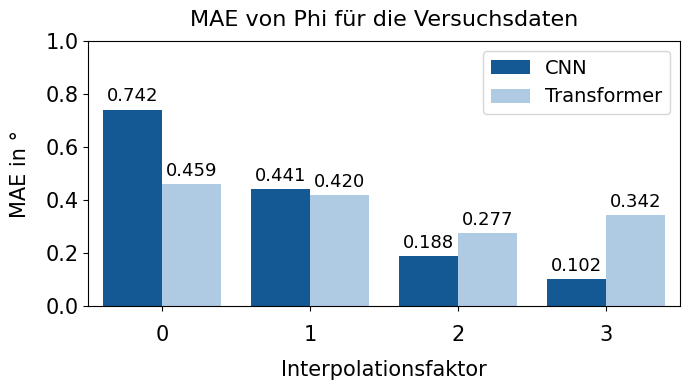

In [7]:
import pandas as pd
# print(MAEs_Interpolation_CNN)
# print(MAEs_Interpolation_Transformer)

Ordner = r'C:\Users\corvi\OneDrive - stud.tu-darmstadt.de\Desktop\Masterthesis\13_ExcelvonDaten_Code\Interpolation'

MAEs_ges =pd.read_csv(f'{Ordner}\Vergleich_CNN_Tranformer_Random11_Intfaktor0_3_x.csv', na_values='N/A', delimiter= ';')

for Column in MAEs_ges.columns[2:]:
        MAEs_ges[Column] = MAEs_ges[Column].astype(str).str.replace(',', '.')
        MAEs_ges[Column] = MAEs_ges[Column].astype(float)
        
MAEs_ges = MAEs_ges.iloc[:,1:]

print(MAEs_ges)

# Ersetzen der NAn Werte mit den Werten für die gesamten Testdaten für den Interpolationsfaktor 0
for metric in ['MAE_X', 'MAE_Y', 'MAE_Phi']:
    MAEs_ges[f'{metric}_Versuchsdaten'] = MAEs_ges.apply(lambda row: row[f'{metric}_AlleDaten'] if pd.isna(row[f'{metric}_Versuchsdaten']) and row['Interpolationsfaktor'] == 0.0 else row[f'{metric}_Versuchsdaten'], axis=1)

print(MAEs_ges)
#Für die Auswahl aller Testdaten
MAEs_ges  = MAEs_ges.iloc[:, [0, 1, 2,3,4,5, 6, 7, 8]]

#print(type(MAEs_ges.iloc[0,2]))

#print(MAEs_ges)

# Filtern der Daten, um Interpolationsfaktor 0 zu überspringen für die Versuchsdaten
#MAEs_ges = MAEs_ges[MAEs_ges['Interpolationsfaktor'] != 0.0]

# Filtern der Daten für CNN und Transformer
#selected_columns_cnn = MAEs_ges[MAEs_ges['Modell'] == 'CNN']

print(MAEs_ges)

# Beispielhafter Plot für MAE Testdaten
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Plot der MAE's aller konventionellen Methoden in Gegenüberstellung der unterschiedlichen Splits

color_thesis1 =(0, 90/255, 169/255) # Dunkelblau aus Thesis
color_thesis2 =(166/255, 202/255, 236/255)  #Hellblau aus Abbildungen

Labels_alle = ['MAE_X_AlleDaten', 'MAE_Y_AlleDaten', 'MAE_Phi_AlleDaten']
Labels_Versuch = ['MAE_X_Versuchsdaten', 'MAE_Y_Versuchsdaten', 'MAE_Phi_Versuchsdaten']
Y_Achse = ['MAE in mm', 'MAE in mm', 'MAE in °']
Titles_alle = ['MAE von X für die gesamten Testdaten', 'MAE von Y für die gesamten Testdaten', 'MAE von Phi für die gesamten Testdaten']
Titles_Versuch = ['MAE von X für die Versuchsdaten', 'MAE von Y für die Versuchsdaten', 'MAE von Phi für die Versuchsdaten']

custom_palette = sns.color_palette([color_thesis1,color_thesis2])

Sicherungsordner = f'C:\\Users\\corvi\\OneDrive - stud.tu-darmstadt.de\\Desktop\\Masterthesis\\15_Plots\\Interpolation'     
# Sicherstellen, dass das Verzeichnis existiert
os.makedirs(Sicherungsordner, exist_ok=True)

# Schleife durch Metriken (X, y, phi)
for index, (Label_alle ,Label_Versuch, Y_Achs, title) in enumerate(zip(Labels_alle, Labels_Versuch, Y_Achse, Titles_Versuch)):
    plt.figure(figsize=(7, 4))

    ax = sns.barplot(data=MAEs_ges, x='Interpolationsfaktor', y=Label_Versuch, hue='Modell', palette=custom_palette)
    plt.title(f'{title}', fontsize=16, pad=11)
    plt.xlabel('Interpolationsfaktor', fontsize=15, labelpad=11)
    plt.ylabel(f'{Y_Achs}', fontsize=15, labelpad=11)
    
    # Werte auf den Balken anzeigen
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.3f}', 
                    xy=(p.get_x() + p.get_width() / 2, height), 
                    xytext=(0, 3),  
                    textcoords="offset points", 
                    ha='center', va='bottom', fontsize=13)
        
        # Anpassen der Legende, um Titel dieser zu entfernen 
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles[0:2], labels[0:2], title=None, fontsize=14)
        
        # Problem mit Beschriftung der Balken (krzeut immer den Rand des Diagramms), deshalb wird hier der höchste Wert ermittelt und eine Obergrenze festgelegt
        max_value = MAEs_ges[Label_alle].max()  # Höchster Balkenwert
        plt.ylim(0, 1)
        
        
        # Ticks Größe ändern
        ax.tick_params(axis='x', labelsize=15, pad=10)  # Größe der x-Achsen-Ticks
        ax.tick_params(axis='y', labelsize=15)  # Größe der y-Achsen-T  
        
        # Explizite Festlegung der x-Achsen-Ticks auf 1, 2, 3 ohne Dezimalstellen
        ax.set_xticks(range(len(MAEs_ges['Interpolationsfaktor'].unique())))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(MAEs_ges["Interpolationsfaktor"].unique()[x])}'))
            
        plt.tight_layout()
        
        
        plt.savefig(os.path.join(Sicherungsordner, f'{Label_Versuch}_Random11.svg'), format='svg')    
        plt.savefig(os.path.join(Sicherungsordner, f'{Label_Versuch}_Random11.png'), format='png')      

plt.show()

        Modell   CV  Interpolationsfaktor  MAE_X_AlleDaten  MAE_Y_AlleDaten  \
0          CNN  8.0                   0.0         0.063074         0.443995   
1          CNN  8.0                   1.0         0.040509         0.226560   
2          CNN  8.0                   2.0         0.007411         0.184267   
3          CNN  8.0                   3.0         0.008644         0.154092   
4  Transformer  8.0                   0.0         0.439519         0.595153   
5  Transformer  8.0                   1.0         0.070168         0.333524   
6  Transformer  8.0                   2.0         0.025615         0.209138   
7  Transformer  8.0                   3.0         0.025431         0.228624   

   MAE_Phi_AlleDaten  MAE_X_Versuchsdaten  MAE_Y_Versuchsdaten  \
0           0.716825                  NaN                  NaN   
1           0.389057             0.023753             0.429000   
2           0.250934             0.014263             0.381932   
3           0.197692    

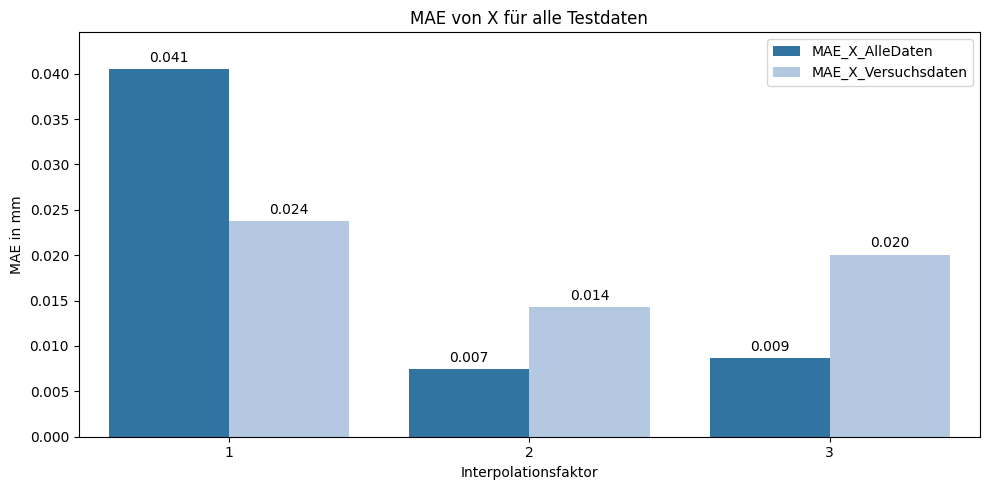

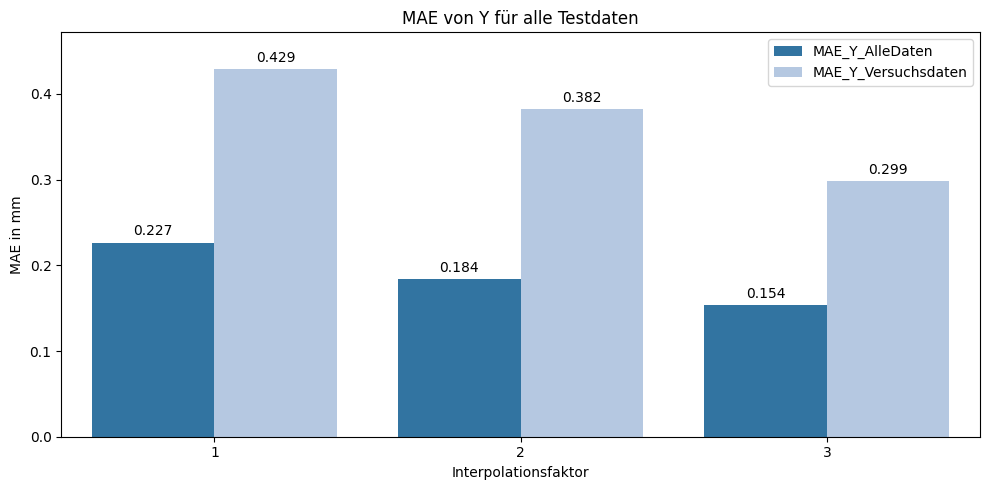

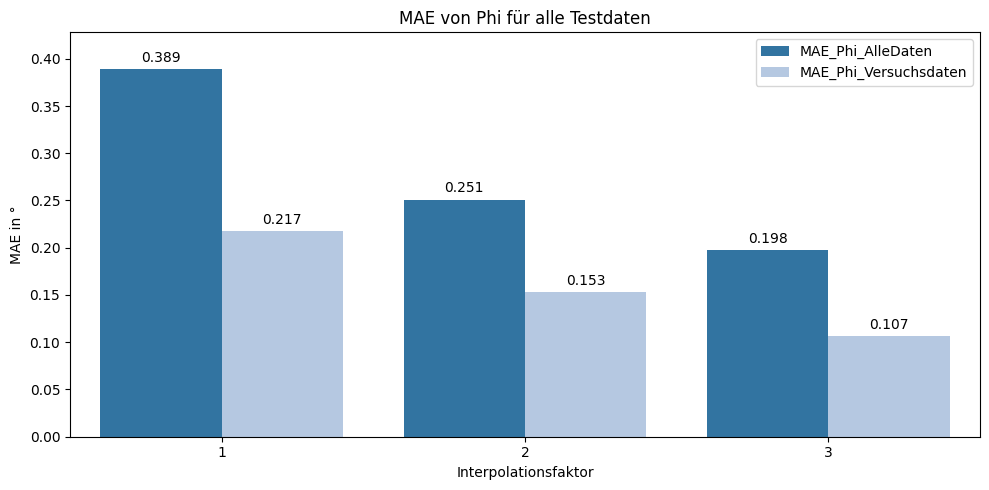

In [73]:
# Plots für den Vergleich zwischen den gesamten Testdaten und den Testdaten die nur über die Versuche aufgenommen werden

import pandas as pd
# print(MAEs_Interpolation_CNN)
# print(MAEs_Interpolation_Transformer)

Ordner = r'C:\Users\corvi\OneDrive - stud.tu-darmstadt.de\Desktop\Masterthesis\13_ExcelvonDaten_Code\Interpolation'

MAEs_ges =pd.read_csv(f'{Ordner}\Vergleich_CNN_Tranformer_Random8_Intfaktor0_3.csv', na_values='N/A', delimiter= ';')

for Column in MAEs_ges.columns[2:]:
        MAEs_ges[Column] = MAEs_ges[Column].astype(str).str.replace(',', '.')
        MAEs_ges[Column] = MAEs_ges[Column].astype(float)
        
MAEs_ges = MAEs_ges.iloc[:,1:]

print(MAEs_ges)

for metric in ['MAE_X', 'MAE_Y', 'MAE_Phi']:
    MAEs_ges[f'{metric}_Versuchsdaten'] = MAEs_ges.apply(lambda row: row[f'{metric}_AlleDaten'] if pd.isna(row[f'{metric}_Versuchsdaten']) and row['Interpolationsfaktor'] == 0.0 else row[f'{metric}_Versuchsdaten'], axis=1)

print(MAEs_ges)
#Für die Auswahl aller Testdaten
# MAEs_ges  = MAEs_ges.iloc[:, [0, 1, 2, 6, 7, 8]]

#print(type(MAEs_ges.iloc[0,2]))

#print(MAEs_ges)

# Filtern der Daten, um Interpolationsfaktor 0 zu überspringen für die Versuchsdaten
MAEs_ges = MAEs_ges[MAEs_ges['Interpolationsfaktor'] != 0.0]

# Filtern der Daten für CNN und Transformer
#selected_columns_cnn = MAEs_ges[MAEs_ges['Modell'] == 'CNN']

print(MAEs_ges)

# Beispielhafter Plot für MAE Testdaten
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Plot der MAE's aller konventionellen Methoden in Gegenüberstellung der unterschiedlichen Splits

Labels = ['MAE_X_AlleDaten', 'MAE_Y_AlleDaten', 'MAE_Phi_AlleDaten']
Labels_Versuch = ['MAE_X_Versuchsdaten', 'MAE_Y_Versuchsdaten', 'MAE_Phi_Versuchsdaten']
Y_Achse = ['MAE in mm', 'MAE in mm', 'MAE in °']
Titles = ['MAE von X für alle Testdaten', 'MAE von Y für alle Testdaten', 'MAE von Phi für alle Testdaten']

custom_palette = sns.color_palette(["#1f77b4", "#aec7e8", "#003f5c", "#7fbc41", "#2ca02c", "#98df8a"])

Sicherungsordner = f'C:\\Users\\corvi\\OneDrive - stud.tu-darmstadt.de\\Desktop\\Masterthesis\\15_Plots\\Interpolation'     
# Sicherstellen, dass das Verzeichnis existiert
os.makedirs(Sicherungsordner, exist_ok=True)

# Schleife durch Metriken (X, y, phi)
for index, (Label ,Label_Versuch, Y_Achs, title) in enumerate(zip(Labels, Labels_Versuch, Y_Achse, Titles)):
    plt.figure(figsize=(8, 4))
    
     # Filtern der Daten für das Modell CNN und die entsprechenden Spalten
    cnn_data = MAEs_ges[(MAEs_ges['Modell'] == 'CNN') & (MAEs_ges['Interpolationsfaktor'].isin([1.0, 2.0, 3.0]))]
    cnn_data = MAEs_ges[MAEs_ges['Modell'] == 'CNN'][['Interpolationsfaktor', Label, Label_Versuch]]
    cnn_data = cnn_data.melt(id_vars=['Interpolationsfaktor'], var_name='Datenart', value_name='MAE')
    
    print(cnn_data)
    
    ax = sns.barplot(data=cnn_data, x='Interpolationsfaktor', y='MAE', hue='Datenart', palette=custom_palette)
    plt.title(f'{title}')
    plt.xlabel('Interpolationsfaktor')
    plt.ylabel(f'{Y_Achs}')
    
    # Werte auf den Balken anzeigen
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.3f}', 
                    xy=(p.get_x() + p.get_width() / 2, height), 
                    xytext=(0, 3),  
                    textcoords="offset points", 
                    ha='center', va='bottom')
        
        # Anpassen der Legende, um Titel dieser zu entfernen 
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles[0:2], labels[0:2], title=None)
        
        # Problem mit Beschriftung der Balken (krzeut immer den Rand des Diagramms), deshalb wird hier der höchste Wert ermittelt und eine Obergrenze festgelegt
        max_value = cnn_data['MAE'].max()  # Höchster Balkenwert
        plt.ylim(0, max_value * 1.1)  # Vergrößern Sie die obere Grenze um 10% über den höchsten Balkenwert
        
        # Explizite Festlegung der x-Achsen-Ticks auf 1, 2, 3 ohne Dezimalstellen
        ax.set_xticks(range(len(cnn_data['Interpolationsfaktor'].unique())))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(cnn_data["Interpolationsfaktor"].unique()[x])}'))
            
        plt.tight_layout()
        
        plt.savefig(os.path.join(Sicherungsordner, f'{Label}_MAE_BarChart_Interpolationsfaktor_Random8_Vergleich_CNN_Test-undVersuchsdaten.svg'), format='svg')    
        plt.savefig(os.path.join(Sicherungsordner, f'{Label}_MAE_BarChart__Interpolationsfaktor_Random8_Vergleich_CNN_Test-undVersuchsdaten.png'), format='png')      

plt.show()